# Analyzing the Shopify Global Catalogue Dataset

Below are all the dependencies we need.

In [1]:
from datasets import load_dataset
from collections import Counter
from matplotlib import pyplot as plt
from io import BytesIO
import base64
import pprint
from mlperf_inference_multimodal_vl2l.task import ShopifyGlobalCatalogue
from openai import OpenAI
import numpy as np

/home/shangw/miniconda3/envs/mlperf-inf/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load the dataset from HuggingFace.

In [ ]:
dataset = load_dataset("Shopify/the-catalogue-public-beta", token="...")

Currenlty, all the samples are in the `train` split, but this might change in the future.

In [3]:
dataset = dataset['train']
print(f"Total number of products: {len(dataset)}")

Total number of products: 239


Display a sample from the dataset, and how that sample would be formulated into a prompt:

An example product at index 24:
title: GLIDE - #65513 Cool Mint
description: <h2 class="page-title-wrapper" style="text-align: center;">40wt. Trilobal Polyester Thread is used for Sewing, Quilting, and Embroidery<span class="base" data-ui-id="page-title-wrapper"></span>
</h2>
category: Arts & Entertainment > Hobbies & Creative Arts > Arts & Crafts > Art & Crafting Materials > Crafting Fibers > Thread & Floss > Sewing Thread
brands: ["n/a"]
standardized_title: Fil-Tec GLIDE Embroidery Thread
standardized_description: Fil-Tec GLIDE Embroidery Thread is perfect for sewing, quilting, and embroidery projects. This high-quality trilobal polyester thread offers a smooth finish and vibrant color, ensuring your projects stand out.

- **Key Features:**
  - Made from durable trilobal polyester
  - Ideal for sewing, quilting, and embroidery
  - Provides a smooth, shiny finish

- **Technical Specifications:**
  - Weight: 40wt
  - Material: Trilobal Polyester
  - Available in King Spool 5000m and Mi

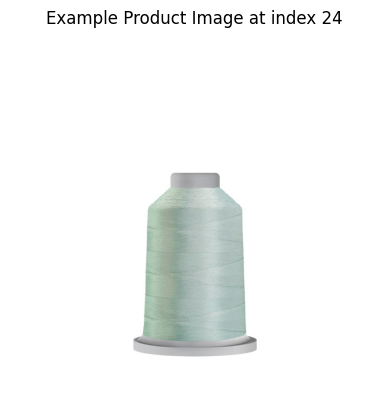

In [4]:
sample_index = 24
print(f"An example product at index {sample_index}:")
for key, value in dataset[sample_index].items():
    print(f"==========\n{key}: {value}")

plt.imshow(dataset[sample_index]["image"])
plt.axis('off')
plt.title(f"Example Product Image at index {sample_index}")
plt.show()


This is how that sample will be formulated into a prompt:

Example prompt (messages):
[{'content': 'Please analyze the following product and provide the following '
             'fields in JSON format:\n'
             '- catagory\n'
             '- standardized_title\n'
             '- standardized_description\n'
             '- brands\n'
             '- is_secondhand\n',
  'role': 'system'},
 {'content': [{'text': 'The title of the product is: GLIDE - #65513 Cool Mint\n'
                       '\n'
                       'The description of the product is: <h2 '
                       'class="page-title-wrapper" style="text-align: '
                       'center;">40wt. Trilobal Polyester Thread is used for '
                       'Sewing, Quilting, and Embroidery<span class="base" '
                       'data-ui-id="page-title-wrapper"></span>\n'
                       '</h2>',
               'type': 'text'},
              {'image_url': {'url': ''},
               'type': 'image_url'}],
  'role': 'user'}]

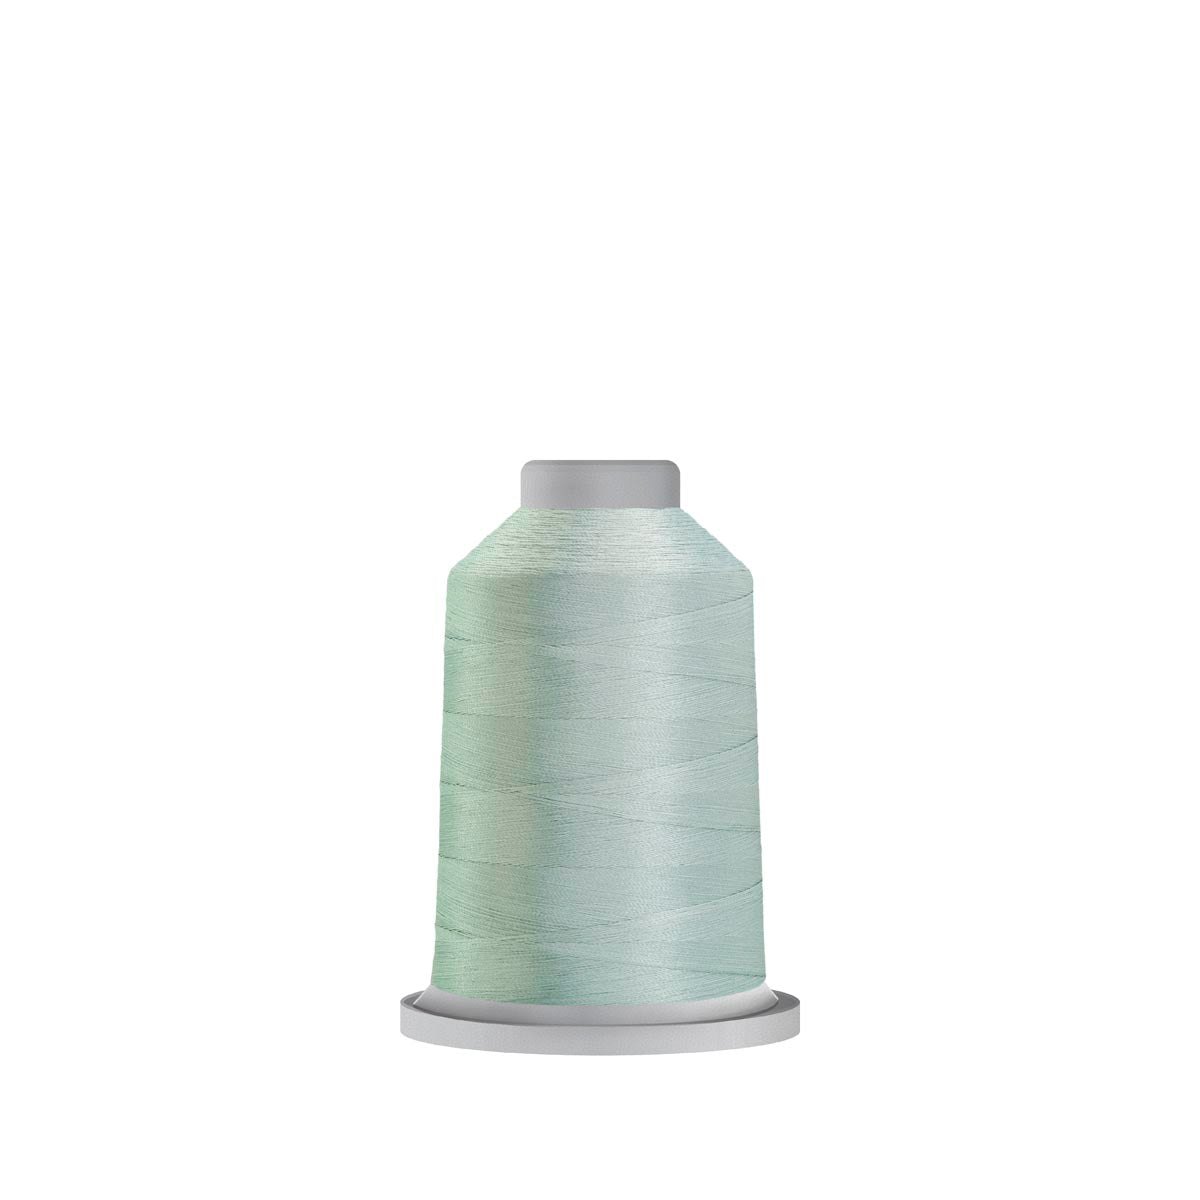

In [5]:
messages = ShopifyGlobalCatalogue.formulate_messages(dataset[sample_index])
print("Example prompt (messages):")
pprint.pprint(messages)

We wanna take a look into the distribution of the various fields.

In [6]:

def count_and_plot_top_n(dataset, value_fn, field_label, n=10):
    """
    Counts occurrences using a custom value extraction function.

    Args:
        dataset: A split of the HuggingFace dataset as returned by load_dataset.
        value_fn: A function (product_dict) -> value, to extract the field to be counted.
        field_label: String label to describe the field when printing (default: function name or 'field').
        n: Number of top frequent items to print.
    """
    values = [value_fn(product) for product in dataset]
    # Remove Nones (missing values)
    values = [v for v in values if v is not None]
    counts = Counter(values)
    top_n = counts.most_common(n)
    import matplotlib.pyplot as plt

    # Use only the top n keys and their counts for the histogram
    keys = [key for key, _ in top_n]
    values = [count for _, count in top_n]

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(keys)), values, tick_label=[str(k) for k in keys])
    plt.title(f"Top {n} {field_label}")
    plt.xlabel(f"{field_label.title()}")
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    assert counts.total() == len(dataset), f"Counts total {counts.total()} does not match dataset length {len(dataset)}"

Top 50 categories are:

/tmp/ipykernel_3006835/3193122340.py:28: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


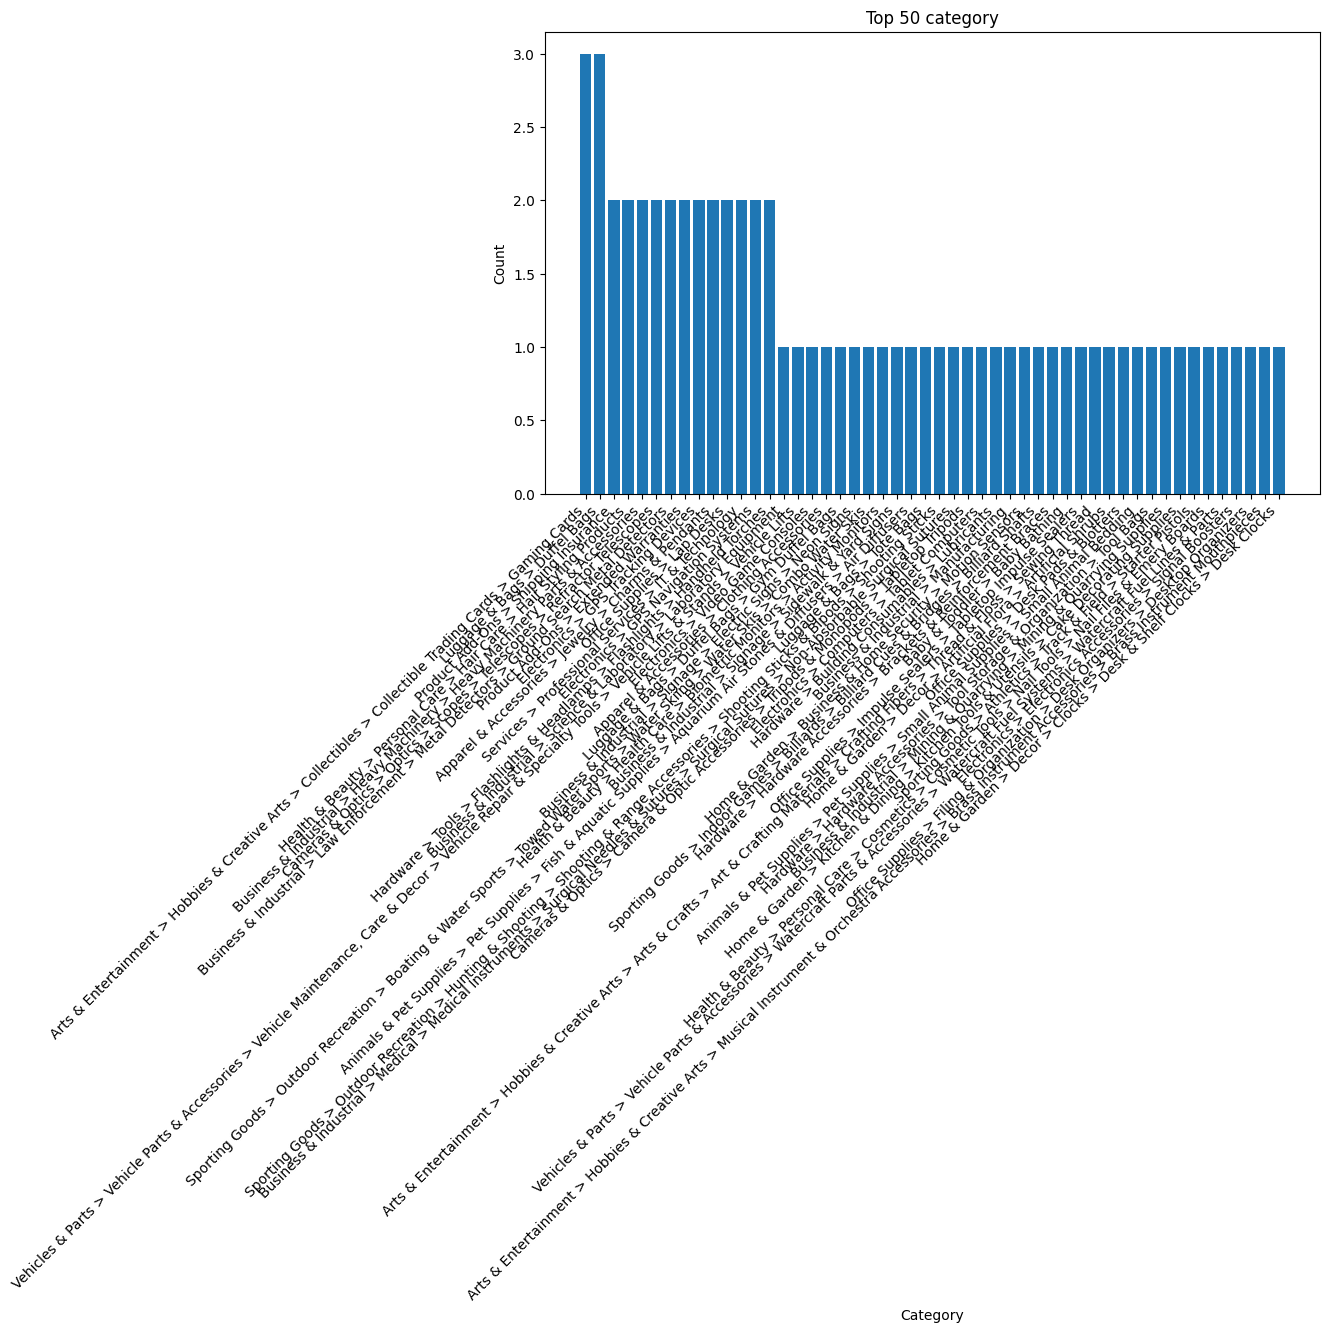

In [7]:
count_and_plot_top_n(dataset, lambda p: p.get('category'), field_label='category', n=50)

There seems to be a lot of unique categories. The VLM doesn't know a priori the entire list of categories to choose from.

Potential solutions are:
1. Passing the entire list of categories as part of the system prompt to the VLM. 
   However, this would make the system prompt too long.
2. From K: Do some sort of semantic similarity search and return a list of 20 or so 
   categories and then ask the VLM to pick one. Shopify already plan on doing this,
   since it would decouple the model from changes to the taxonomy.

Top 50 brands are:

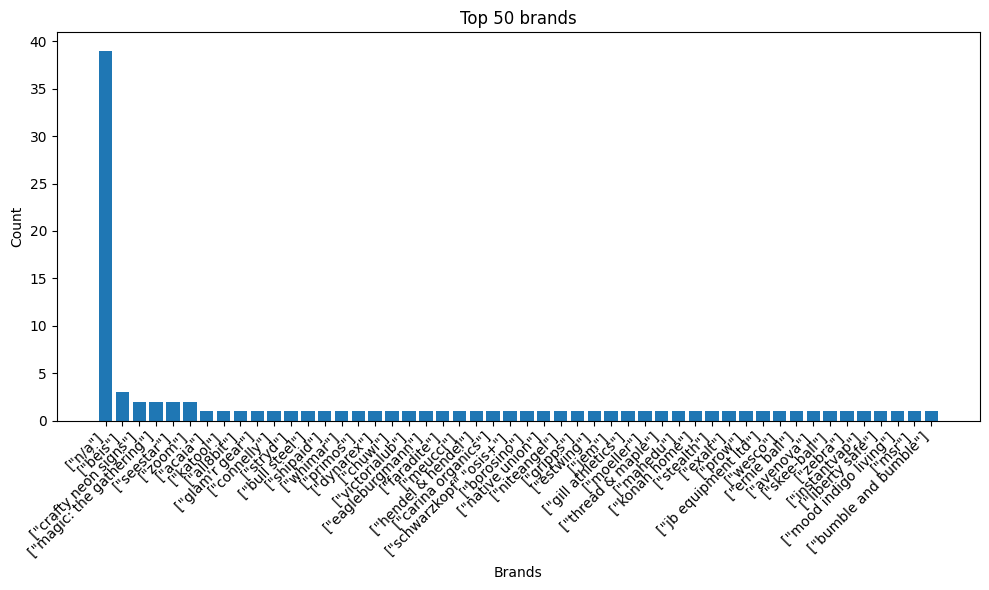

In [8]:
count_and_plot_top_n(dataset, lambda p: p.get('brands'), field_label='brands', n=50)

Brands seem to have a similar issue as the categories. There seems to be a lot of unique brands.

The distribution of secondhand vs. new products are:

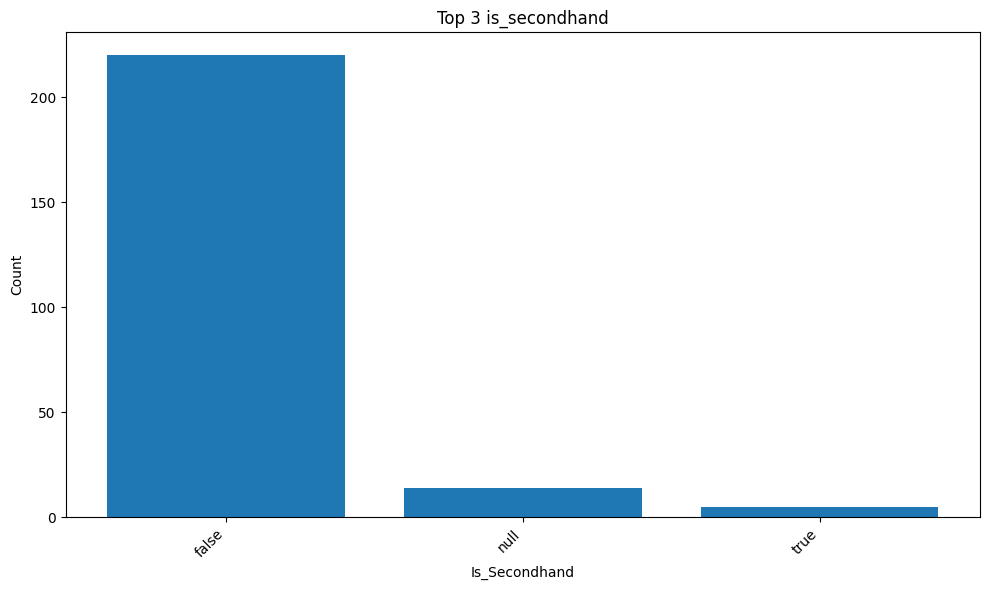

In [9]:
count_and_plot_top_n(dataset, lambda p: p.get('is_secondhand'), field_label='is_secondhand', n=3)

The distribution of the image sizes are:

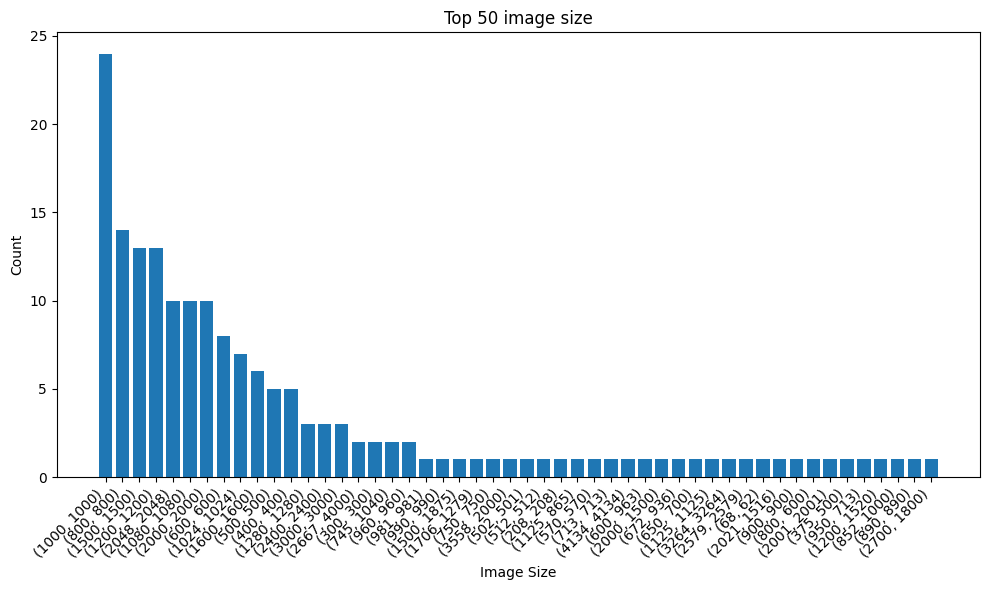

In [10]:
count_and_plot_top_n(dataset, lambda p: (p.get('image').width, p.get('image').height), field_label='image size', n=50)

The distribution of the number of visual tokens is:

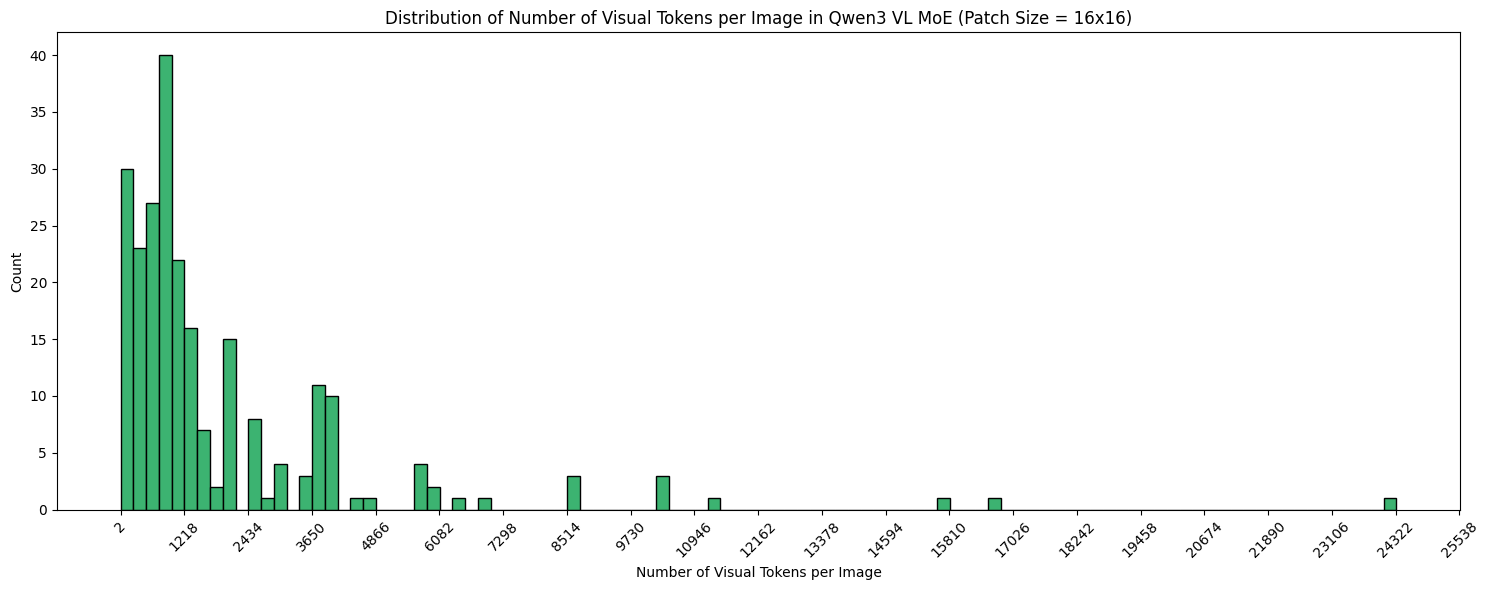

In [11]:
patch_size = 16
spatial_merge_size = 2

num_visual_tokens = [
    (p['image'].width // patch_size // spatial_merge_size) * (p['image'].height // patch_size // spatial_merge_size)
    for p in dataset
    if p.get('image') is not None
]

plt.figure(figsize=(15,6))
hist_vals, bin_edges, _ = plt.hist(num_visual_tokens, bins=100, color='mediumseagreen', edgecolor='black')
plt.title(f"Distribution of Number of Visual Tokens per Image in Qwen3 VL MoE (Patch Size = {patch_size}x{patch_size})")
plt.xlabel("Number of Visual Tokens per Image")

tick_step = int((max(num_visual_tokens) - min(num_visual_tokens)) / 20)  # 20 ticks
if tick_step > 0:
    ticks = np.arange(min(num_visual_tokens), max(num_visual_tokens) + tick_step, tick_step)
    plt.xticks(ticks, rotation=45)

plt.ylabel("Count")
plt.tight_layout()
plt.show()


The image file formats are:

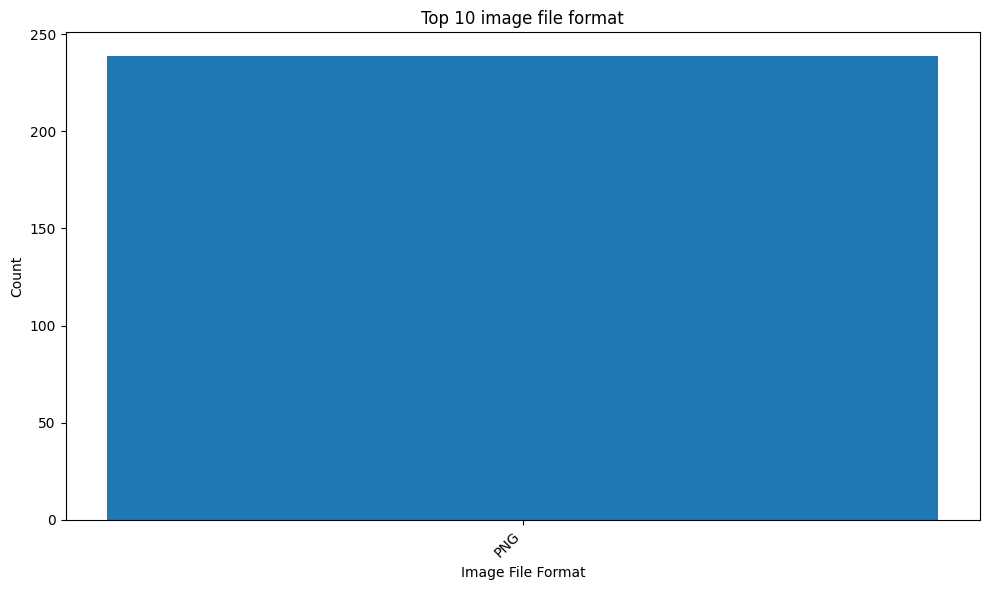

In [12]:
count_and_plot_top_n(dataset, lambda p: p['image'].format, field_label='image file format', n=10)

Send the requests to the inference endpoint and gather the responses.

In [13]:
openai_api_client = OpenAI(api_key="", base_url="http://localhost:8000/v1")
responses = [
    openai_api_client.chat.completions.create(
        model="Qwen/Qwen3-VL-30B-A3B-Instruct",
        messages=ShopifyGlobalCatalogue.formulate_messages(product),
    ) for product in dataset
]
prompt_tokens_counter = Counter(response.usage.prompt_tokens for response in responses)
completion_tokens_counter = Counter(response.usage.completion_tokens for response in responses)
total_tokens_counter = Counter(response.usage.total_tokens for response in responses)    

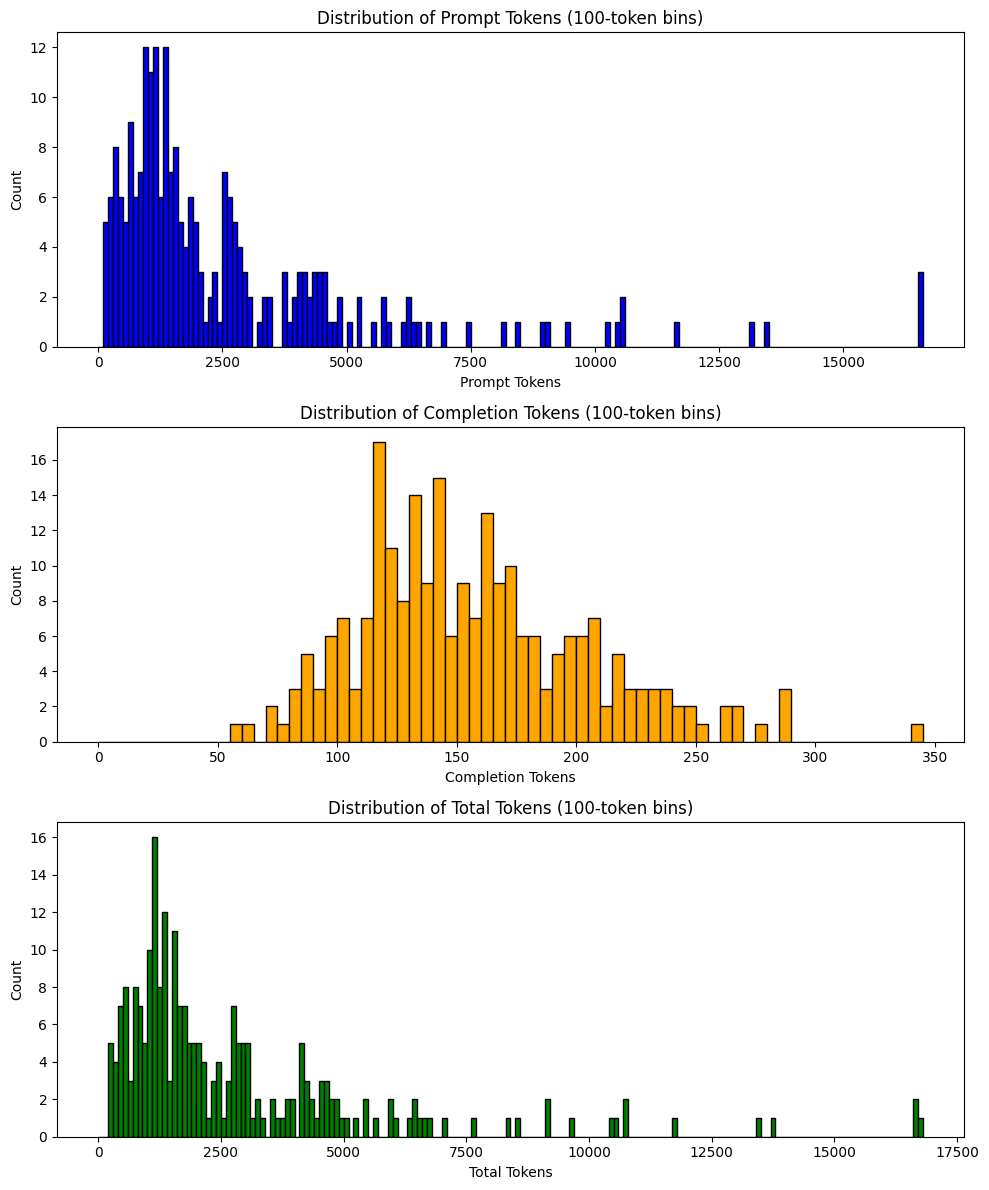

In [14]:
import numpy as np

# Convert Counters to lists of token counts (each count per response)
prompt_tokens = []
for token_count, freq in prompt_tokens_counter.items():
    prompt_tokens.extend([token_count] * freq)
completion_tokens = []
for token_count, freq in completion_tokens_counter.items():
    completion_tokens.extend([token_count] * freq)
total_tokens = []
for token_count, freq in total_tokens_counter.items():
    total_tokens.extend([token_count] * freq)

# Define bins in intervals of a specified bin_size, up to max token count (rounded up to next bin_size)
def get_bins(data, bin_size=100):
    max_val = max(data) if len(data) > 0 else bin_size
    bins = np.arange(0, ((max_val // bin_size) + 2) * bin_size, bin_size)
    return bins


fig, axs = plt.subplots(3, 1, figsize=(10, 12))

# Histogram for prompt_tokens
axs[0].hist(prompt_tokens, bins=get_bins(prompt_tokens), color='blue', edgecolor='black')
axs[0].set_title("Distribution of Prompt Tokens (100-token bins)")
axs[0].set_xlabel("Prompt Tokens")
axs[0].set_ylabel("Count")

# Histogram for completion_tokens
axs[1].hist(completion_tokens, bins=get_bins(completion_tokens, bin_size=5), color='orange', edgecolor='black')
axs[1].set_title("Distribution of Completion Tokens (100-token bins)")
axs[1].set_xlabel("Completion Tokens")
axs[1].set_ylabel("Count")

# Histogram for total_tokens
axs[2].hist(total_tokens, bins=get_bins(total_tokens), color='green', edgecolor='black')
axs[2].set_title("Distribution of Total Tokens (100-token bins)")
axs[2].set_xlabel("Total Tokens")
axs[2].set_ylabel("Count")

plt.tight_layout()
plt.show()
